<h1>Feedback Prize - English Language Learning</h1>

<h2>Reading data</h2>

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.optimizers import Adam
import transformers

from tensorflow import keras
from sklearn.model_selection import train_test_split

train = pd.read_csv('../input/feedback-prize-english-language-learning/train.csv')
test = pd.read_csv('../input/feedback-prize-english-language-learning/test.csv')

In [53]:
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [54]:
test.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


<h2>Wordcloud Visualization</h2>

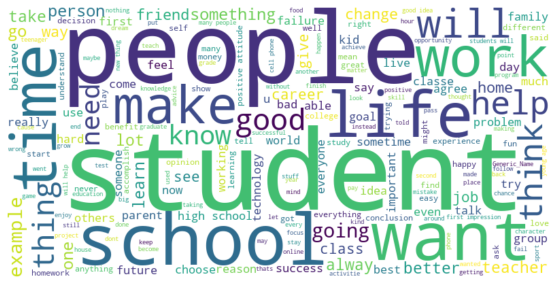

In [55]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(train.full_text))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<h2>Preprocessing with BERT</h2>

In [56]:
MAX_LENGTH = 512
OFFLINE_TOKENIZER = "../input/bert-cased-base"
tokenizer = transformers.BertTokenizer.from_pretrained(OFFLINE_TOKENIZER, do_lower_case=True)


In [58]:
def tokenize_sentences(texts):
    encoded = tokenizer.batch_encode_plus(
            texts,
            add_special_tokens=True,
            max_length=MAX_LENGTH,
            return_attention_mask=True,
            return_token_type_ids=True,
            truncation=True,
            return_tensors="tf",
            padding='max_length')
    return encoded['input_ids']

tokenized_train = tokenize_sentences(train['full_text'])
tokenized_test = tokenize_sentences(test['full_text'])

In [62]:
#tokenized_train = pd.DataFrame(tokenized_train, columns=["col_"+str(i) for i in range(512)])
#tokenized_test = pd.DataFrame(tokenized_test, columns=["col_"+str(i) for i in range(512)])

<h2>Model building</h2>

In [69]:
"""features = ["col_"+str(i) for i in range(512)]
targets = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]

X = tokenized_train[features]
y = train[targets]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_val.shape", X_val.shape, "y_val.shape", y_val.shape)"""

features = ["col_"+str(i) for i in range(512)]
targets = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]

X = tokenized_train
y = train[targets]

X_train, X_val, y_train, y_val = train_test_split(X.numpy(), y, test_size=0.2, random_state=1)

In [70]:
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]

    inputs = keras.Input(shape=(512,))
    flatten = keras.layers.Flatten()
    dense1 = keras.layers.Dense(500, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_))
    dense2 = Dense(125, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_))
    dense3 = Dense(125, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_))
    dense4 = keras.layers.Dense(6)

    x = flatten(inputs)
    x = dense1(x)
    outputs = dense4(x)

    models[i] = keras.Model(inputs = inputs, outputs = outputs)

    models[i].compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )
    models[i].fit(
        X_train, y_train,
        epochs=100,
        verbose=0
    )
    print(f"finished lambda: {lambda_}")

finished lambda: 0.0
finished lambda: 0.001
finished lambda: 0.01
finished lambda: 0.05
finished lambda: 0.1
finished lambda: 0.2
finished lambda: 0.3


In [71]:
best_score = 100000
best_model = 0
for m in models:
    score = m.evaluate(X_val, y_val)
    print(score)
    if score < best_score:
        best_score = score
        best_model = m

25/25 [==============================] - 0s 1ms/step - loss: 0.8549
0.8549139499664307
25/25 [==============================] - 0s 2ms/step - loss: 4.1913
4.191332817077637
25/25 [==============================] - 0s 1ms/step - loss: 16.3039
16.303897857666016
25/25 [==============================] - 0s 1ms/step - loss: 56.7209
56.72089385986328
25/25 [==============================] - 0s 1ms/step - loss: 107.4623
107.46234130859375
25/25 [==============================] - 0s 1ms/step - loss: 172.1715
172.17149353027344
25/25 [==============================] - 0s 1ms/step - loss: 241.5587
241.55865478515625


In [72]:
print("prev_score: ", best_score)
best_model.fit(X_val, y_val, epochs=100)
score = best_model.evaluate(X_val, y_val)
print("Eval Score: ", score)


prev_score:  0.8549139499664307
Epoch 1/100
25/25 [==============================] - 0s 2ms/step - loss: 0.8486
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 0.8353
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 0.8225
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 0.8099
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7975
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7855
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7738
Epoch 8/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7623
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7511
Epoch 10/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7403
Epoch 11/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7295
Epoch 12/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7192
Epoch

In [73]:
score = best_model.evaluate(X_train, y_train)
print("Train Score: ", score)

98/98 [==============================] - 0s 1ms/step - loss: 0.4259
Train Score:  0.42585819959640503


In [75]:
X_sub = tokenized_test

res = best_model.predict(X_sub)
res

array([[3.0493054, 2.9854047, 3.2312138, 3.1266758, 3.0300248, 3.1055622],
       [3.0493054, 2.9854047, 3.2312138, 3.1266758, 3.0300248, 3.1055622],
       [3.0493054, 2.9854047, 3.2312138, 3.1266758, 3.0300248, 3.1055622]],
      dtype=float32)

In [76]:
def myround(x, prec=2, base=.5):
  return round(base * round(float(x)/base),prec)

rounded_res = [[] for i in range(3)]
for i in range(len(res)):
    for j in range(len(res[i])):
        rounded_res[i].append(myround(x = res[i][j]))
rounded_res

[[3.0, 3.0, 3.0, 3.0, 3.0, 3.0],
 [3.0, 3.0, 3.0, 3.0, 3.0, 3.0],
 [3.0, 3.0, 3.0, 3.0, 3.0, 3.0]]

In [57]:
submission = pd.concat([test['text_id'], pd.DataFrame(rounded_res, columns = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'])], axis=1)
submission.to_csv("./data/submission.csv", index = False)